# Aggregate contrail outputs

- Authors: Marc Shapiro, Zeb Engberg
- Date: 2023-04-14
- `pycontrails`: v0.40.1

Run CoCiP on a set of flights and calculate aggregate statistics.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/contrailcirrus/2023-04-pycontrails-workshop/blob/main/notebooks/03-CoCiP-output.ipynb)

## Goals

### Load Data

1. Load a sample of pre-processed flight data from 2020-01-01
2. Load meteorology data from ECMWF for the waypoints in this space

### Run CoCiP

1. Calculate contrail evolution using `CoCiP`
2. Calculate aggregate statistics across time and space

## Download data

This downloads about 15 GB on data (ADS-B and gridded weather). We recommend you run this in Colab.

In [ ]:
# GCP Bucket with sample data
GCP_BUCKET = "gs://2023-04-pycontrails-workshop"

# make data/ directory
!mkdir -p data/flight/sample

# sync all data files locally (~15 GB)
!gsutil -m rsync {GCP_BUCKET}/data/flight/sample data/flight/sample
!gsutil -m rsync {GCP_BUCKET}/data/met data/met
!gsutil -m rsync {GCP_BUCKET}/data/rad data/rad

## Load global flight data

In [1]:
import pandas as pd

from pycontrails import Flight, Fleet
from pycontrails.physics import units

In [2]:
# Read metadata extracted for this day 2020-01-01
metadata = pd.read_parquet("data/flight/sample/metadata.pq")
metadata.set_index("flight_id", inplace=True)
metadata.head()

,callsign,icao_address,flight_number,tail_number,aircraft_type_icao,aircraft_engine_type,origin_airport,origin_airport_name,origin_country,destination_airport,...,time_last_waypoint,duration_hours,total_distance_km,n_waypoints,aircraft_type_bada,engine_name,engine_uid,n_engine,wingspan,total_fuel_burn
flight_id,,,,,,,,,,,,,,,,,,,,,
200101-13143-CES2847,CES2847,780F92,MU2847,B-8497,A320,Jet,ZYTL,Dalian Zhoushuizi International Airport,CN,ZLXY,...,2020-01-01 01:49:52,1.82,1308.78,127,A320-232,V2527-A5,01P10IA021,2,34.10,5089.527896
200101-26467-UAL14,UAL14,A8D3B4,UA14,N668UA,B763,Jet,KEWR,Newark Liberty International Airport,US,EGLL,...,2020-01-01 06:41:06,6.67,5709.01,582,B763ERGE61,CF6-80C2B6F,01P02GE188,2,47.57,28756.589855
200101-538-QTR6WF,QTR6WF,06A138,,A7-BAV,B77W,Jet,OTHH,Hamad International Airport,QA,,...,2020-01-01 01:30:19,1.48,1473.83,125,B773ERGE115B,GE90-115B,01P21GE217,2,64.80,12781.202921
200101-7216-AAR2981,AAR2981,71BC21,OZ2981,HL7421,B744,Jet,RKSI,Incheon International Airport,KR,PANC,...,2020-01-01 07:16:35,7.24,6644.90,474,B744GE,CF6-80C2B1F,01P02GE186,4,64.44,69388.115648
200101-7217-AAR795,AAR795,71BC23,OZ795,HL7423,B744,Jet,RKSI,Incheon International Airport,KR,UUDD,...,2020-01-01 08:51:59,8.78,6916.06,765,B744GE,CF6-80C2B1F,01P02GE186,4,64.44,86396.950684


In [3]:
waypoints = pd.read_parquet("data/flight/sample/waypoints.pq")
waypoints = waypoints.set_index("flight_id")

# 51644 unique waypoints in this domain
len(waypoints)

51644

Load waypoints into a list of `Flight` objects

The flight data necessary to run CoCiP is:

- `flight_id` - str or int
- `longitude` - WGS84
- `latitude` - WGS84
- `altitude` - meters

To run CoCiP without using an aircraft performance model (e.g. BADA), you need the additional data:

- `engine_efficiency`
- `fuel_flow` - kg s**-1
- `aircraft_mass` - kg
- `nvpm_ei_n` - # kg**-1
- `wingspan` - meters

Here we will grab the pre-computed aircraft performance to avoid running processing emissions

In [4]:
# load metadata and create Flight instances
flights = []
for fid, group in waypoints.groupby(waypoints.index):

    # Aircraft and engine properties
    attrs = {
        "flight_id": fid,
        "wingspan": metadata.loc[fid, "wingspan"],
        "aircraft_type": metadata.loc[fid, "aircraft_type_icao"],
    }

    # Create flight object
    fl = Flight(data=group, attrs=attrs)
    flights.append(fl)

len(flights)

100

## Load data from ECMWF

### Load from staged files using the ERA5 interface

- NetCDF files in `data/met` contain pressure level data for all required `CoCiP` meteorology variables.
- NetCDF files in `data/rad` contain single level data for all required `CoCiP` radiation variables.

In [5]:
from pycontrails.datalib.ecmwf import ERA5

#### Set domain

This is always required, even if the file only contains the dimensions / variables necessary.

In [6]:
time = "2020-01-01T00", "2020-01-02T08"

# select variables by standard name
pressure_level_variables = [
    "air_temperature",
    "specific_humidity",
    "eastward_wind",
    "northward_wind",
    "lagrangian_tendency_of_air_pressure",
    "specific_cloud_ice_water_content",
    "geopotential",
]

single_level_variables = [
    "top_net_solar_radiation",
    "top_net_thermal_radiation"
]

# select pressure levels from meteorology
pressure_levels = [
    1000,
    975,
    950,
    925,
    900,
    875,
    850,
    825,
    800,
    775,
    750,
    700,
    650,
    600,
    550,
    500,
    450,
    400,
    350,
    300,
    250,
    225,
    200,
    175,
    150,
    125,
    100,
]

In [7]:
# Load ERA5 data from local files
era5pl = ERA5(
    time=time,
    variables=pressure_level_variables,
    pressure_levels=pressure_levels,
    paths="data/met/*.nc",
    cachestore=None,
)
era5sl = ERA5(
    time=time,
    variables=single_level_variables,
    paths="data/rad/*.nc",
    cachestore=None,
)

# Open MetDataset from sources
met = era5pl.open_metdataset(xr_kwargs=dict(parallel=False))
rad = era5sl.open_metdataset(xr_kwargs=dict(parallel=False))

This next cell is unnecessary since we've already staged the data above. 

Executing it would allow you to download new domains automatically

In [ ]:
# Download and cache ERA5 files for this domain
# Note you must have an account with CDS for this to work
# Provide API credentials in the inputs below
era5pl = ERA5(
    time=time,
    variables=pressure_level_variables,
    pressure_levels=pressure_levels,
    # url="https://cds.climate.copernicus.eu/api/v2",
    # key="<key>"
)
era5sl = ERA5(
    time=time,
    variables=single_level_variables,
    # url="https://cds.climate.copernicus.eu/api/v2",
    # key="<key>"
)

# Open MetDataset from sources
# This is the step where the data is downloaded
met = era5pl.open_metdataset(xr_kwargs=dict(parallel=False))
rad = era5sl.open_metdataset(xr_kwargs=dict(parallel=False))

## Run CoCiP model

In [8]:
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import ExponentialBoostHumidityScaling

Customize model params.
See [CocipParams](https://py.contrails.org/api/pycontrails.models.cocip.CocipParams.html#pycontrails.models.cocip.CocipParams) for a list of possible parameters.

In [9]:
# create a humidity correction based on Teoh 2022
humidity_scaling = ExponentialBoostHumidityScaling()

In [10]:
params = {
    "dt_integration": pd.Timedelta(5, "m"),
    "max_age": pd.Timedelta(12, "h"),
    "humidity_scaling": humidity_scaling,
}

In [11]:
cocip = Cocip(met, rad, params)

In [12]:
%%time
# evaluate CoCiP over 100 flights
cocip.eval(flights);

/Users/marcshapiro/computing/contrailcirrus/pycontrails/pycontrails/core/vector.py:895: UserWarning: Found duplicate key wingspan in attrs and data. Set `overwrite=True` parameter to force overwrite.
  warnings.warn(


In [13]:
# retrieve the contrail output
contrails = cocip.contrail

In [14]:
# print out a sample
contrails.sample(5)

,waypoint,flight_id,formation_time,time,age,longitude,latitude,altitude,level,continuous,...,tau_contrail,dn_dt_agg,dn_dt_turb,rf_sw,rf_lw,rf_net,persistent,ef,timestep,age_hours
248,353,200101-5933-EIN10X,2020-01-01 06:20:20,2020-01-01 15:00:00,0 days 08:39:40,-4.076324,58.119627,11513.600064,208.710279,True,...,0.047553,6.089721e-18,0.000003,-0.335504,3.231674,2.896170,True,6.054119e+11,174,8.661111
392,26,200101-36885-KNE121,2020-01-01 01:28:06,2020-01-01 02:35:00,0 days 01:06:54,45.592076,25.850774,10563.382403,242.339572,True,...,0.142406,4.125473e-17,0.000007,0.000000,10.132627,10.132627,True,1.402703e+11,25,1.115000
695,176,200101-26445-UAL134,2020-01-01 03:27:41,2020-01-01 05:40:00,0 days 02:12:19,-55.167818,54.736902,10329.203931,251.304228,True,...,0.316160,3.506095e-18,0.000004,0.000000,8.168880,8.168880,True,1.483666e+10,62,2.205278
305,172,200101-23219-DAL216,2020-01-01 03:11:02,2020-01-01 05:10:00,0 days 01:58:58,-51.636199,34.326565,9896.164537,268.588493,True,...,0.558153,9.846078e-16,0.000013,0.000000,15.675274,15.675274,True,1.943805e+11,56,1.982778
887,33,200101-29376-SWG562,2020-01-01 03:19:08,2020-01-01 06:55:00,0 days 03:35:52,-95.995766,28.602345,11404.753867,212.323495,True,...,0.023400,1.199617e-18,0.000001,0.000000,1.099274,1.099274,True,8.811647e+10,77,3.597778


In [15]:
contrails.shape

(257202, 56)

## Analyze Results

In [16]:
# possible columns to aggregate
contrails.columns

Index(['waypoint', 'flight_id', 'formation_time', 'time', 'age', 'longitude',
       'latitude', 'altitude', 'level', 'continuous', 'segment_length',
       'sin_a', 'cos_a', 'width', 'depth', 'sigma_yz', 'air_temperature',
       'specific_humidity', 'air_pressure', 'rhi', 'rho_air', 'q_sat',
       'n_ice_per_m', 'iwc', 'u_wind', 'v_wind', 'vertical_velocity',
       'tau_cirrus', 'air_temperature_lower', 'u_wind_lower', 'v_wind_lower',
       'dT_dz', 'ds_dz', 'dsn_dz', 'sdr', 'top_net_solar_radiation', 'rsr',
       'top_net_thermal_radiation', 'olr', 'area_eff', 'plume_mass_per_m',
       'r_ice_vol', 'terminal_fall_speed', 'diffuse_h', 'diffuse_v',
       'n_ice_per_vol', 'tau_contrail', 'dn_dt_agg', 'dn_dt_turb', 'rf_sw',
       'rf_lw', 'rf_net', 'persistent', 'ef', 'timestep', 'age_hours'],
      dtype='object')

### Flight statistics

These statistics characterize a full flight

In [17]:
# create a dataframe that is indexed by flight_id and waypoint
flight_index = contrails.set_index("flight_id").sort_index().index
flight_summary = pd.DataFrame(
    data=None,
    index=flight_index
)
flight_summary.head(3)

""
flight_id
200101-10205-CSN3281
200101-10205-CSN3281
200101-10205-CSN3281


In [18]:
%%time

# aggregate by a few example columns
for idx, gp in contrails.groupby("flight_id"):
    flight_summary.loc[idx, "ef"] = gp["ef"].sum()
    flight_summary.loc[idx, "mean_lifetime"] = gp["age_hours"].mean()

CPU times: user 90.6 ms, sys: 12 ms, total: 103 ms
Wall time: 100 ms


In [19]:
flight_summary.head()

,ef,mean_lifetime
flight_id,,
200101-10205-CSN3281,-4.292140e+11,0.220433
200101-10205-CSN3281,-4.292140e+11,0.220433
200101-10205-CSN3281,-4.292140e+11,0.220433
200101-10205-CSN3281,-4.292140e+11,0.220433
200101-10205-CSN3281,-4.292140e+11,0.220433


### Flight waypoints summary statistics

These statistics characterize a single contrail segment.

In [20]:
# create a dataframe that is indexed by flight_id and waypoint
waypoint_index = contrails.set_index(["flight_id", "waypoint"]).sort_index().index
waypoint_summary = pd.DataFrame(
    data=None,
    index=waypoint_index
)
waypoint_summary.head(3)

Empty DataFrame
Columns: []
Index: [(200101-10205-CSN3281, 138), (200101-10205-CSN3281, 138), (200101-10205-CSN3281, 138)]

In [21]:
%%time

# aggregate by a few example columns
for idx, gp in contrails.groupby(["flight_id", "waypoint"]):
    waypoint_summary.loc[idx, "olr_mean"] = gp["olr"].mean()
    waypoint_summary.loc[idx, "sdr_mean"] = gp["sdr"].mean()
    waypoint_summary.loc[idx, "rf_net"] = gp["rf_net"].mean()
    waypoint_summary.loc[idx, "mean_lifetime"] = gp["age_hours"].mean()

CPU times: user 4.23 s, sys: 33.3 ms, total: 4.26 s
Wall time: 4.25 s


In [22]:
waypoint_summary.head()

olr_mean    sdr_mean    rf_net  mean_lifetime
flight_id            waypoint                                                 
200101-10205-CSN3281 138       236.940659  525.923178 -2.640492       0.179167
                     138       236.940659  525.923178 -2.640492       0.179167
                     138       236.940659  525.923178 -2.640492       0.179167
                     138       236.940659  525.923178 -2.640492       0.179167
                     139       238.895523  544.323020 -5.029093       0.286389

In [23]:
import tempfile

import gcsfs
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ModuleNotFoundError: No module named 'cartopy'

### Time-slice statistics

These statistics characterize a single time.

In [ ]:
def time_to_goes_gcs_path(time: pd.Timestamp) -> list[str]:

    assert time.second == 0, "time must be a multiple of 5 minutes"
    assert time.minute % 5 == 0, "time must be a multiple of 5 minutes"
    
    year = time.strftime("%Y")
    yday = time.strftime("%j")
    hour = time.strftime("%H")

    
    bucket = "gcp-public-data-goes-16"
    sensor = "ABI"  # Advanced Baseline Imager
    level = "L2"  # Level 2
    product_name = "CMIP"  # Cloud and Moisture Imagery
    region = "C"  # CONUS
    channels = "C11", "C14", "C15"
    
    
    product = f"{sensor}-{level}-{product_name}{region}"

    path_prefix = f"gs://{bucket}/{product}/{year}/{yday}/{hour}/"

    # https://www.goes-r.gov/users/abiScanModeInfo.html
    scan_mode = "M6"

    # Very crude -- assuming scan time ends with 1 or 6 for CONUS
    time += pd.Timedelta("1T")
    
    time_str = time.strftime("%Y%j%H%M")

    name_prefix = f"OR_{product[:-1]}{region}-{scan_mode}"
    name_suffix = f"_G16_s{time_str}*"
    
    fs = gcsfs.GCSFileSystem()

    rpaths = [f"{path_prefix}{name_prefix}{c}{name_suffix}" for c in channels]
    rpaths = [fs.glob(rpath) for rpath in rpaths]
    return [rpath for rpath, in rpaths]


def load_at_time(time: pd.Timestamp) -> xr.DataArray:

    rpaths = time_to_goes_gcs_path(time)
    lpaths = [rpath.split("/")[-1] for rpath in rpaths]
    fs = gcsfs.GCSFileSystem()

    with tempfile.TemporaryDirectory() as tmpdir:
        lpaths = [f"{tmpdir}/{lpath}" for lpath in lpaths]
        fs.get(rpaths, lpaths)
        ds = xr.open_mfdataset(
            lpaths,
            concat_dim="band",
            combine="nested",
            compat="override",
            data_vars=["CMI"],
            coords="minimal",
        )
        
    ds = ds.swap_dims({"band": "band_id"})
    da = ds["CMI"]

    # Attach some useful attrs -- only using goes_imager_projection currently
    da.attrs["goes_imager_projection"] = ds.goes_imager_projection.attrs
    da.attrs["geospatial_lat_lon_extent"] = ds.geospatial_lat_lon_extent.attrs

    return da


def clip_and_scale(arr: np.ndarray, low: float, high: float) -> np.ndarray:
    return (arr.clip(low, high) - low) / (high - low)


def to_ash(da: xr.DataArray) -> np.ndarray:
    c11 = da.sel(band_id=11).values  # 8.44
    c14 = da.sel(band_id=14).values  # 11.19
    c15 = da.sel(band_id=15).values  # 12.27

    red = c15 - c14
    green = c14 - c11
    blue = c14

    red = clip_and_scale(red, -4, 2)
    green = clip_and_scale(green, -4, 5)
    blue = clip_and_scale(blue, 243, 303)

    return np.dstack([red, green, blue])

In [24]:
time_slice_index = contrails.set_index(["time"]).sort_index().index
time_slice_summary = pd.DataFrame(
    data=None,
    index=time_slice_index
)

In [25]:
%%time
# aggregate by a few example columns
for idx, gp in contrails.groupby("time"):
    time_slice_summary.loc[idx, "olr_mean"] = gp["olr"].mean()
    time_slice_summary.loc[idx, "sdr_mean"] = gp["sdr"].mean()
    time_slice_summary.loc[idx, "rf_net"] = gp["rf_net"].mean()
    time_slice_summary.loc[idx, "mean_lifetime"] = gp["age_hours"].mean()

CPU times: user 133 ms, sys: 13.5 ms, total: 146 ms
Wall time: 143 ms


In [26]:
time_slice_summary.head()

,olr_mean,sdr_mean,rf_net,mean_lifetime
time,,,,
2020-01-01 00:30:00,268.475311,0.0,19.465209,0.021852
2020-01-01 00:30:00,268.475311,0.0,19.465209,0.021852
2020-01-01 00:30:00,268.475311,0.0,19.465209,0.021852
2020-01-01 00:35:00,272.138367,0.0,16.107754,0.055444
2020-01-01 00:35:00,272.138367,0.0,16.107754,0.055444


## Grid outputs by space

Aggregate contrail waypoints within lat/lon bounds

In [27]:
# grid by quarter degree bins
grid = 0.25
lat = np.arange(-80, 80, grid)
lon = np.arange(-180, 180, grid)

In [28]:
# add columns to contrails to represent the bounds
contrails["lon_grid"] = lon[np.searchsorted(lon + grid, contrails["longitude"].values)]
contrails["lat_grid"] = lat[np.searchsorted(lat + grid, contrails["latitude"].values)]

In [29]:
grid_index = contrails.set_index(["lon_grid", "lat_grid"]).sort_index().index
grid_summary = pd.DataFrame(
    data=None,
    index=grid_index
)
grid_summary.head()

Empty DataFrame
Columns: []
Index: [(-139.75, 17.25), (-139.75, 17.25), (-139.75, 17.25), (-139.75, 17.25), (-139.75, 17.5)]

In [30]:
%%time

A_region = 510072000e3  # Area of the earth m²
# aggregate by a few example columns
for idx, gp in contrails.groupby(["lon_grid", "lat_grid"]):
    ef_sum = gp["ef"].sum()
    grid_summary.loc[idx, "rf_mean"] = ef_sum / (A_region * 365 * 24 * 60 * 60)

CPU times: user 3.27 s, sys: 28.7 ms, total: 3.3 s
Wall time: 3.29 s


In [33]:
# NOTE - this is only for 100 flights! global average `rf_mean` is small
grid_summary.head()

rf_mean
lon_grid lat_grid              
-139.75  17.25     1.178072e-10
         17.25     1.178072e-10
         17.25     1.178072e-10
         17.25     1.178072e-10
         17.50     1.979976e-10

In [21]:
time = pd.Timestamp("2020-01-01T21")
da = load_at_time(time)
contrail = contrails.loc[time]

rgb = to_ash(da)

geos = da.attrs["goes_imager_projection"]
x = da.x.values
y = da.y.values

extent = np.r_[x.min(), x.max(), y.min(), y.max()]
extent *= geos["perspective_point_height"]

transform = ccrs.Geostationary(
    central_longitude=geos["longitude_of_projection_origin"],
    satellite_height=geos["perspective_point_height"],
    sweep_axis="x",
)

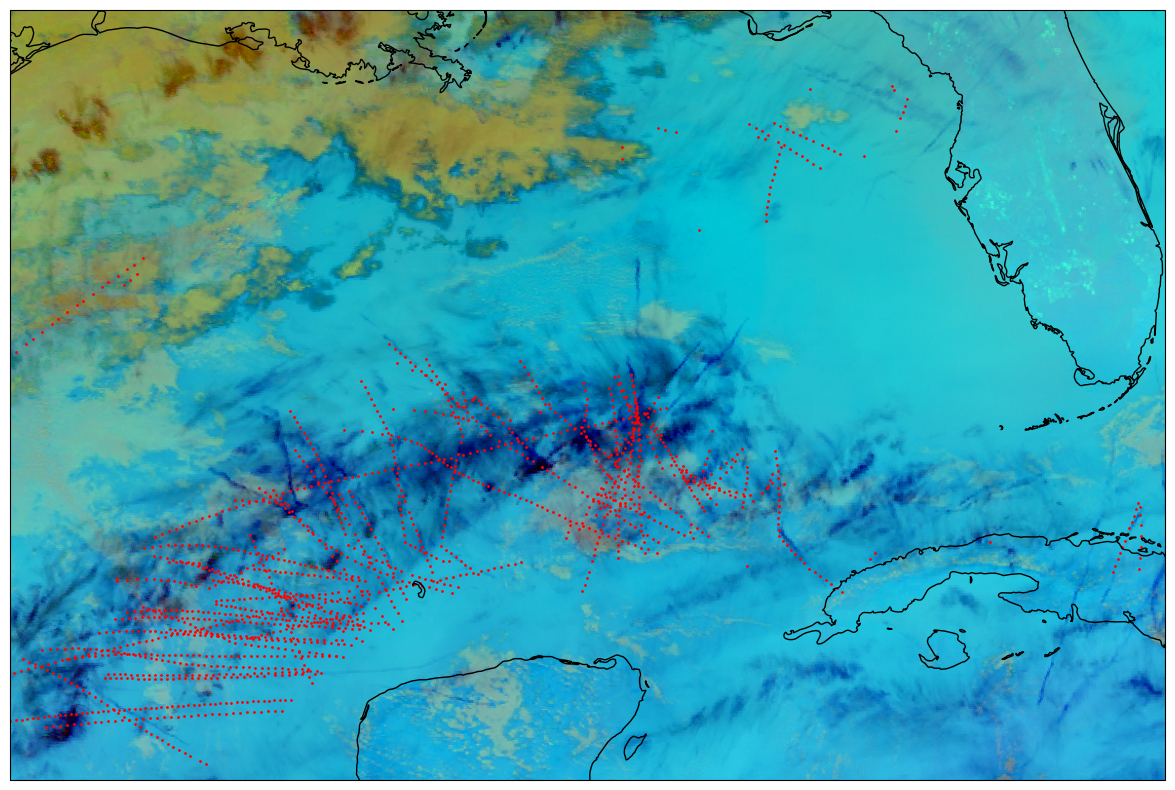

In [22]:
fig = plt.figure(figsize=(16, 10))
pc = ccrs.PlateCarree()
ax = fig.add_subplot(projection=pc, extent=bbox)
ax.coastlines()
ax.imshow(rgb, extent=extent, transform=transform)
ax.scatter(contrail["longitude"], contrail["latitude"], color="red", s=1);